In [3]:
!pip install --upgrade sagemaker
!pip install torch==2.1.2
!pip install torchvision==0.16.2

  Using cached torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl (209.8 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [1]:
import ast
import boto3
import numpy as np
import os
import sagemaker
import torch
import torchvision
from sagemaker.pytorch.model import PyTorchModel
import cv2
from PIL import Image

from urllib.parse import urlparse
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
aws_region = boto3.Session().region_name
role_arn = sagemaker.get_execution_role()

In [3]:
import torchvision

def get_model(device='cpu', model_name='v2'):
    # Load the model.
    if model_name == 'v2':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
            weights='DEFAULT'
        )
    elif model_name == 'v1':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
            weights='DEFAULT'
        )
    # Load the model onto the computation device.
    model = model.eval().to(device)
    return model

In [59]:
model = get_model()

# torch.save(model.state_dict(), './model_dir/fasterrcnn_resnet50_fpn.pth')
# torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
scripted_model = torch.jit.script(model)
scripted_model.save("model.pth")

In [3]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [6]:
def draw_boxes(boxes, classes, labels, image):
    """
    Draws the bounding box around a detected object.
    """

    lw = 1
    tf = 1
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            img=image,
            pt1=(int(box[0]), int(box[1])),
            pt2=(int(box[2]), int(box[3])),
            color=color[::-1], 
            thickness=lw
        )
        cv2.putText(
            img=image, 
            text=classes[i], 
            org=(int(box[0]), int(box[1]-5)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw / 3, 
            color=color[::-1], 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image

In [122]:
!pip install sagemaker-inference

  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker-inference: filename=sagemaker_inference-1.10.1-py2.py3-none-any.whl size=29728 sha256=60de254a7c75b300fcae90d3496a155f4738860a62a9d9757cb23afe845f20cb
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4f/d8/2a/300a5f9c1dbc89f931aff8eaba60a81bd5c9b814c9d4a0f2de
Successfully built sagemaker-inference


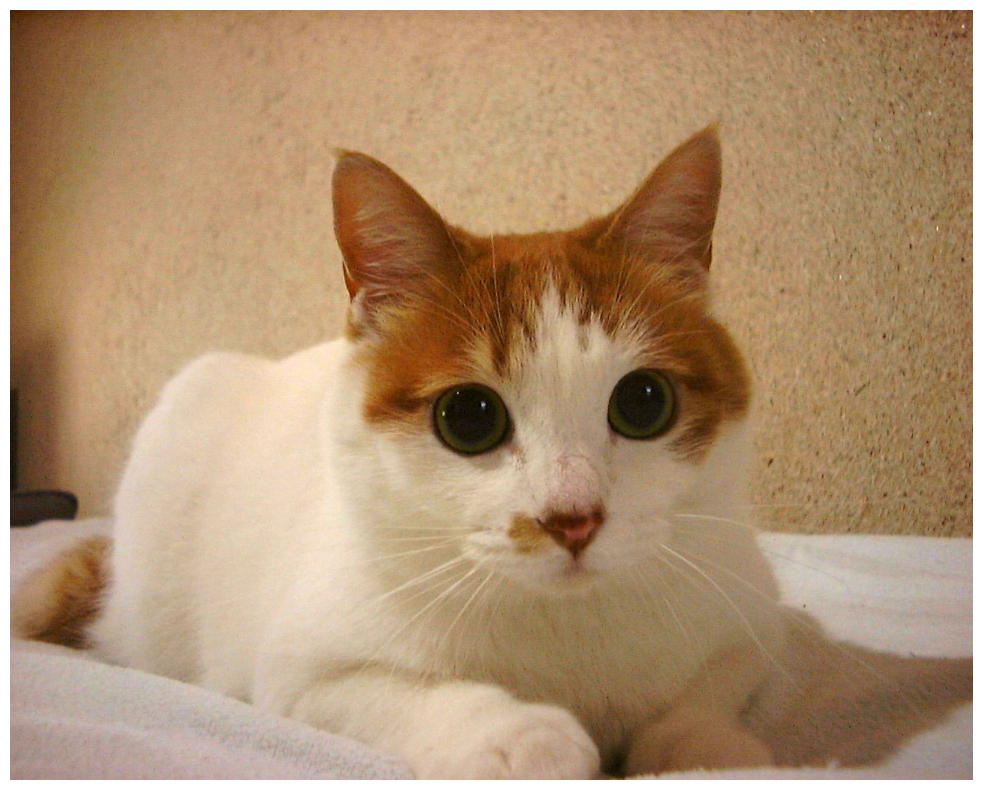

Image shape before normalization: (1280, 1024)
Normalized shape: (3, 1024, 1280)
Swapped shape: (1024, 1280, 3)


code/__torch__/torchvision/models/detection/faster_rcnn.py:103: UserWarning: RCNN always returns a (Losses, Detections) tuple in scripting


[0.99435461 0.51540774 0.48536533 0.29912451 0.26002508 0.12879495
 0.10530814 0.10220148 0.06699812]
[[  73  137 1226 1024]]
[17]
['cat']


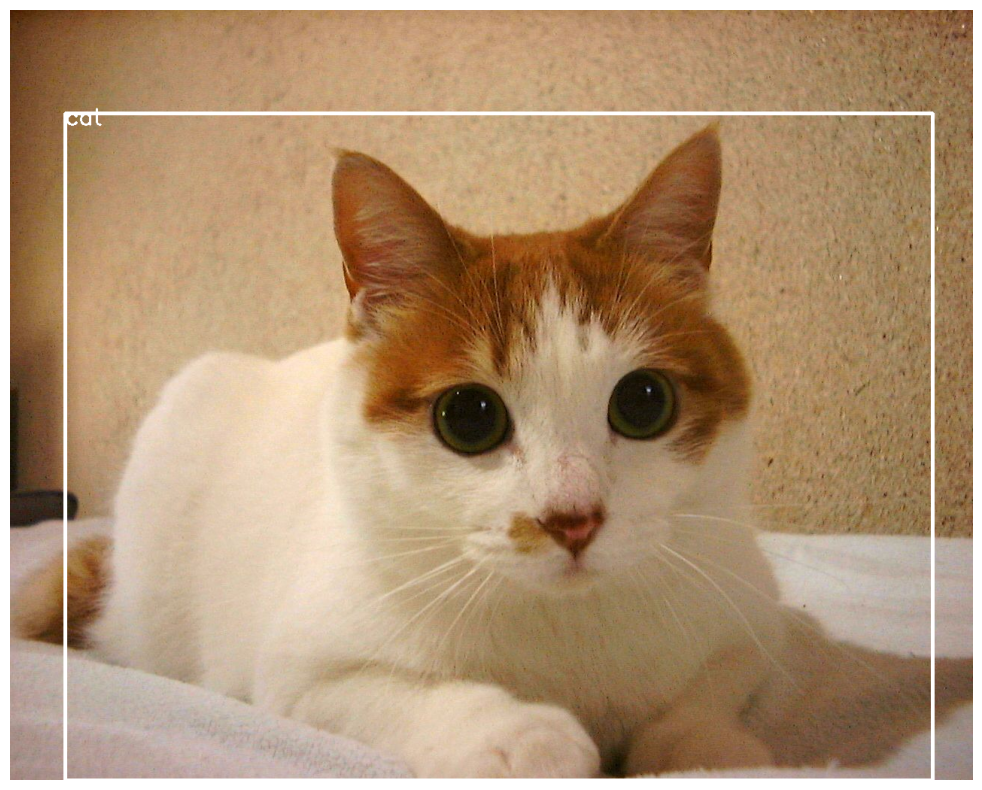

In [12]:

import torch
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import os
import io
import json
from model_dir.inference import model_fn, output_fn, input_fn
from urllib import request
import base64

try:

    image_url = "https://images.freeimages.com/images/large-previews/bd1/cat-1404368.jpg"

    # Download the image from the URL
    image_data = request.urlopen(image_url).read()
    encoded_image = base64.b64encode(image_data).decode('utf-8')


    # Convert the binary image data to a NumPy array
    image_array = np.asarray(bytearray(image_data), dtype=np.uint8)

    # Open the image using Pillow
    image = Image.open(io.BytesIO(image_array))

    # Display the image using Matplotlib
    plt.figure(figsize=(15, 10))

    plt.axis('off')  # Turn off axis labels    
    plt.imshow(image)
    plt.show()

    # Load the scripted model
    model = torch.jit.load("model.pth")
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    current_directory = os.getcwd()
    model = model_fn(model_dir=current_directory)

    #print('hera?')
    image_new = input_fn(encoded_image)
    #print('he23423ra?')

    image_bgr = cv2.cvtColor(np.array(image_new), cv2.COLOR_RGB2BGR)
    
    preprocess = transforms.Compose([transforms.ToTensor()])
    normalized = preprocess(image_new)

    with torch.no_grad():

        outputs = model([normalized])

        output_data_string = output_fn(outputs, 'application/json')
        output_data = json.loads(output_data_string)
        # Access the second element in the tuple as losses/detections
        boxes = output_data[1][0].get("boxes", [])

        pred_scores = np.array(output_data[1][0].get("scores", []))
        pred_bboxes = np.array(output_data[1][0].get("boxes", []))

        # Thresholding correction
        detection_threshold = 0.9
        boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
        labels = np.array(output_data[1][0].get("labels", [])[:len(boxes)])
        pred_classes = [coco_names[i] for i in labels]

        print(pred_scores)
        print(boxes)
        print(labels)
        print(pred_classes)

    for i, box in enumerate(boxes):
        lw = max(round(sum(image_bgr.shape) / 2 * 0.003), 2)  # Line width.
        tf = max(lw - 1, 1)  # Font thickness.
        color = COLORS[labels[i]]
        cv2.rectangle(
            img=image_bgr,
            pt1=(int(box[0]), int(box[1])),
            pt2=(int(box[2]), int(box[3])),
            color=color[::-1],
            thickness=lw
        )
        cv2.putText(
            img=image_bgr,
            text=pred_classes[i],
            org=(int(box[0]), int(box[1]+15)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw / 3,
            color=color[::-1],
            thickness=tf,
            lineType=cv2.LINE_AA
        )


    plt.figure(figsize=(15, 10)) 
    plt.imshow(image_bgr)
    plt.axis('off')
    plt.savefig("output.png")  # or use another format like .jpg
    plt.show()


except Exception as e:
    print(f"An exception occurred: {e}")


In [63]:
!tar -czvf model.tar.gz 'model.pth'

model.pth


In [65]:
from sagemaker.s3 import S3Uploader

local_model_path = 'model.tar.gz'
default_bucket = sagemaker.Session().default_bucket()
model_data = S3Uploader.upload(local_model_path, f's3://{default_bucket}/michael-models')
print(f'Model artifacts uploaded to: {default_bucket}')

Model artifacts uploaded to: sagemaker-us-west-1-456461478565


In [77]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel

framework_version = "1.9.1"
python_version = "py38"

# Create a PyTorchModel instance
pytorch_model = PyTorchModel(
    model_data='s3://sagemaker-us-west-1-456461478565/michael-models/model.tar.gz',
    role=role_arn,
    entry_point='./model_dir/inference.py',
    framework_version=framework_version,
    py_version=python_version,
)

predictor = pytorch_model.deploy(instance_type='ml.t2.medium',
                                 initial_instance_count=1)

-------!